In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [15]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [16]:
# verifichiamo la presenza di valori nulli
df = trainDF.toPandas()

featuresNull = df.isnull().sum().sort_values( ascending=False )
print(featuresNull)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64


In [63]:
# creo un UDF per contare il numero di elementi nulli all'interno del dataframe divisi per colonna

from pyspark.sql.functions import col

def null_value_count(df):
  null_columns_counts = []
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [86]:
nullFeaturesTrainDF = spark.createDataFrame(null_value_count(trainDF), ['Features with NA value', 'Count']).sort('Count', ascending=False)
nullFeaturesTrainDF.show()

+----------------------+-----+
|Features with NA value|Count|
+----------------------+-----+
|                PoolQC| 1453|
|           MiscFeature| 1406|
|                 Alley| 1369|
|                 Fence| 1179|
|           FireplaceQu|  690|
|           LotFrontage|  259|
|            GarageQual|   81|
|            GarageType|   81|
|            GarageCond|   81|
|           GarageYrBlt|   81|
|          GarageFinish|   81|
|          BsmtFinType2|   38|
|          BsmtExposure|   38|
|          BsmtFinType1|   37|
|              BsmtQual|   37|
|              BsmtCond|   37|
|            MasVnrType|    8|
|            MasVnrArea|    8|
|            Electrical|    1|
+----------------------+-----+



In [90]:
# calcolo la percentuale di dati mancanti

nullFeaturesTrainDF = nullFeaturesTrainDF.withColumn( "Missing Ratio",  col("Count") / trainDF.count() * 100)
nullFeaturesTrainDF.show()

+----------------------+-----+------------------+
|Features with NA value|Count|     Missing Ratio|
+----------------------+-----+------------------+
|                PoolQC| 1453| 99.52054794520548|
|           MiscFeature| 1406| 96.30136986301369|
|                 Alley| 1369| 93.76712328767123|
|                 Fence| 1179| 80.75342465753424|
|           FireplaceQu|  690| 47.26027397260274|
|           LotFrontage|  259| 17.73972602739726|
|           GarageYrBlt|   81|5.5479452054794525|
|            GarageCond|   81|5.5479452054794525|
|            GarageType|   81|5.5479452054794525|
|          GarageFinish|   81|5.5479452054794525|
|            GarageQual|   81|5.5479452054794525|
|          BsmtExposure|   38|2.6027397260273974|
|          BsmtFinType2|   38|2.6027397260273974|
|              BsmtQual|   37|2.5342465753424657|
|              BsmtCond|   37|2.5342465753424657|
|          BsmtFinType1|   37|2.5342465753424657|
|            MasVnrType|    8| 0.547945205479452|


Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

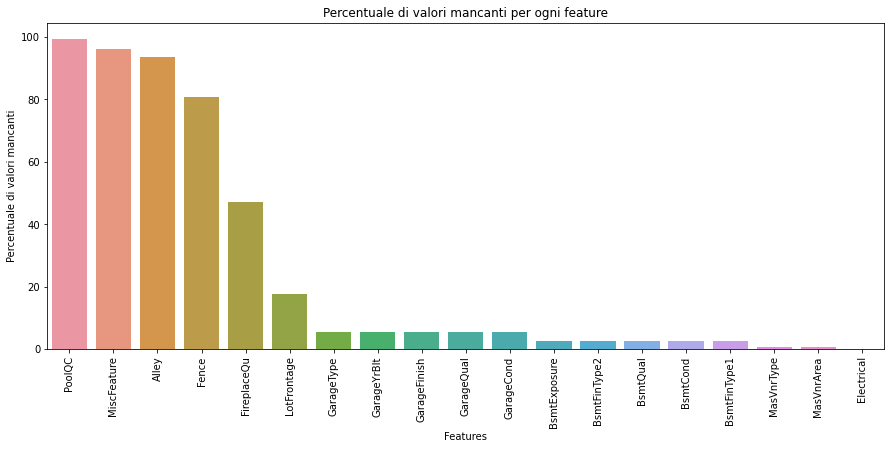

In [91]:
# facciamo un grafico per capire meglio
df_temp = nullFeaturesTrainDF.toPandas()

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=df_temp['Features with NA value'], y=df_temp['Missing Ratio']) 
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [ ]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80% (1168)

theshold = 0.8
n_values_not_null = len(df) * (1 - theshold)
df_clean = df.dropna(axis='columns', thresh=n_values_not_null, inplace=False)

Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

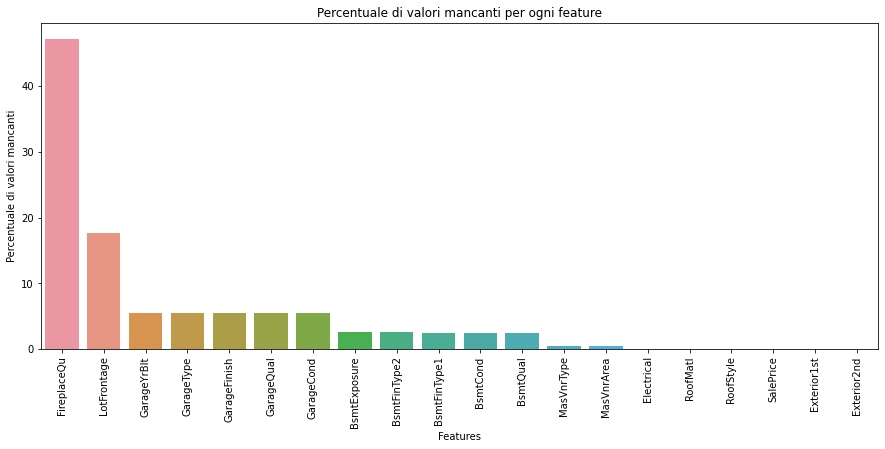

In [ ]:
missing_ratio_2 = ( ( df_clean.isna().sum() / len(df_clean)) * 100 ).sort_values(ascending=False)

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_ratio_2.index[:20], y=missing_ratio_2[:20]) #prendo le prime 20 per visualizzarle meglio
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [ ]:
missing_data = df_clean.isna().sum()
missing_data = missing_data[ missing_data != 0].sort_values(ascending=False)
print(missing_data)

FireplaceQu     690
LotFrontage     259
GarageCond       81
GarageQual       81
GarageFinish     81
GarageYrBlt      81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64


In [ ]:
# controlliamo se il numero di Fireplace impostati a 0 e FireplaceQu = NA coincida
fireplaces = df_clean['Fireplaces']
n_fireplace_0 = fireplaces[fireplaces == 0 ].count()

print(n_fireplace_0)
n_fireplace_0 == missing_data['FireplaceQu']

690


True

In [ ]:
# rimpiazziamo il valore NA con None

df_clean['FireplaceQu'] = df_clean['FireplaceQu'].fillna("None")

missing_data = df_clean.isna().sum()
missing_data = missing_data[ missing_data != 0].sort_values(ascending=False)
print(missing_data)

LotFrontage     260
BsmtFinType2     39
BsmtExposure     39
BsmtQual         38
BsmtFinType1     38
               ... 
KitchenAbvGr      1
KitchenQual       1
TotRmsAbvGrd      1
Functional        1
Id                1
Length: 76, dtype: int64


<ipython-input-24-a327299e633a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['FireplaceQu'] = df_clean['FireplaceQu'].fillna("None")


In [ ]:
# controlliamo se il numero di GarageArea impostati a 0 e GarageCond, GarageQual, GarageFinish, GarageYrBlt,GarageType coincida

n_GarageArea_0 = df_clean['GarageArea'][df_clean['GarageArea']==0].count()
print(n_GarageArea_0)

n_GarageArea_0 == missing_data['GarageCond'] and\
	n_GarageArea_0 == missing_data['GarageQual'] and\
		n_GarageArea_0 == missing_data['GarageFinish'] and\
			n_GarageArea_0 == missing_data['GarageYrBlt'] and\
				n_GarageArea_0 == missing_data['GarageType']
				


81


True

In [ ]:
# rimpiazziamo il valore NA con None

df_clean['GarageCond'] = df_clean['GarageCond'].fillna("None")
df_clean['GarageQual'] = df_clean['GarageQual'].fillna("None")
df_clean['GarageFinish'] = df_clean['GarageFinish'].fillna("None")
df_clean['GarageYrBlt'] = df_clean['GarageYrBlt'].fillna("None")
df_clean['GarageType'] = df_clean['GarageType'].fillna("None")

missing_data = df_clean.isna().sum()
missing_data = missing_data[ missing_data != 0].sort_values(ascending=False)
print(missing_data)

LotFrontage     259
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64


<ipython-input-21-1a0f43026acf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['GarageCond'] = df_clean['GarageCond'].fillna("None")
<ipython-input-21-1a0f43026acf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['GarageQual'] = df_clean['GarageQual'].fillna("None")
<ipython-input-21-1a0f43026acf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

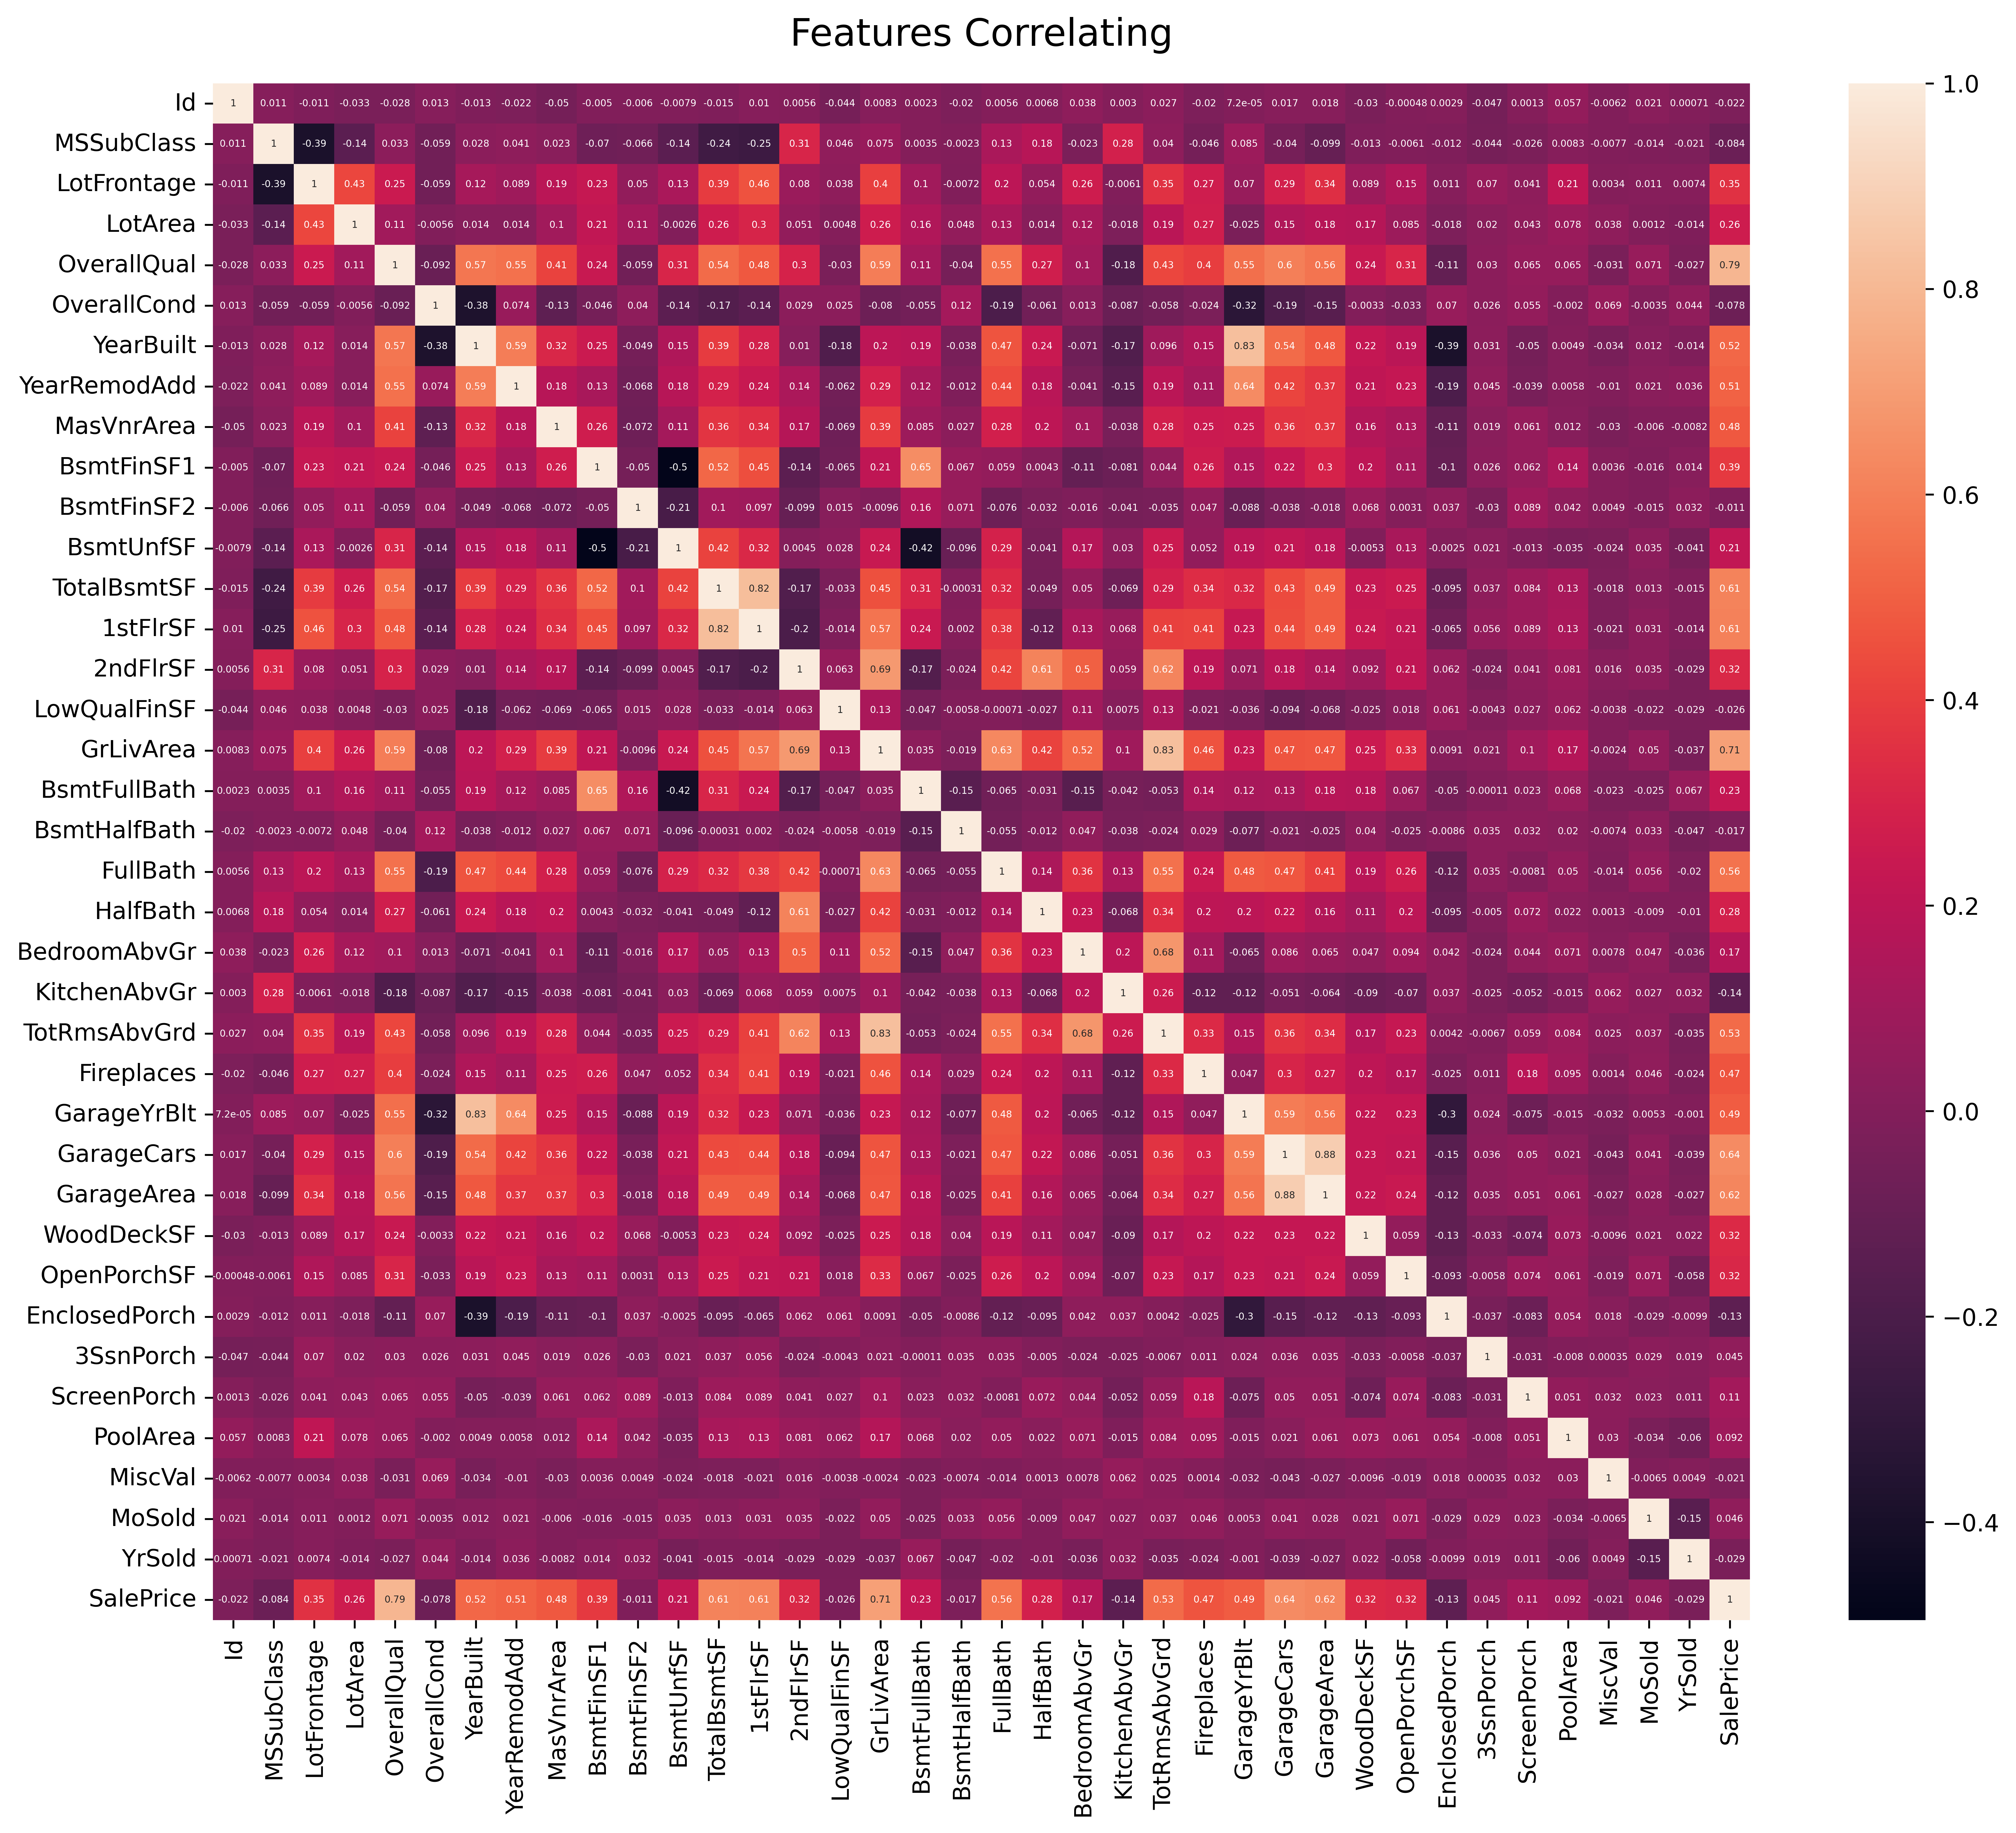

In [ ]:


plt.figure(figsize=(15, 12), dpi = 600) 


corr = df.corr()

sns.heatmap(corr, annot=True, annot_kws={"fontsize":4}, square=True).set_title('Features Correlating', fontdict={'fontsize':16}, pad=16);

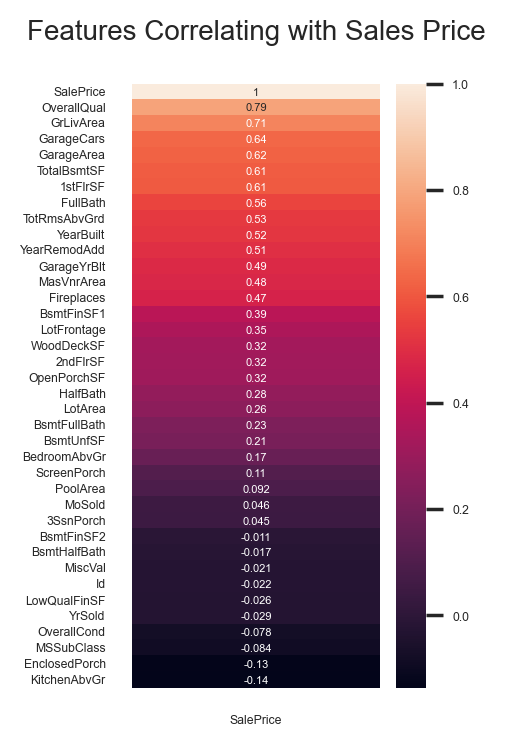

In [ ]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

In [ ]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [ ]:
df_clean.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   Pave      Reg         Lvl   
1   2          20       RL         80.0     9600   Pave      Reg         Lvl   
2   3          60       RL         68.0    11250   Pave      IR1         Lvl   
3   4          70       RL         60.0     9550   Pave      IR1         Lvl   
4   5          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    AllPub    Inside  ...             0         0           0        0   
1    AllPub       FR2  ...             0         0           0        0   
2    AllPub    Inside  ...             0         0           0        0   
3    AllPub    Corner  ...           272         0           0        0   
4    AllPub       FR2  ...             0         0           0        0   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 77 columns]

In [ ]:
print(df_clean['SaleCondition'].unique())

['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
